In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline

np.random.seed(0)

Creating a user-item (100, 30) matrix by taking the dot product of a (100, 5) and (5, 30) matrices.

In [94]:
x = np.abs(np.random.randn(1000, 5)).round(0)
y = np.abs(np.random.randn(5, 300)).round(0)

In [95]:
M = np.dot(x, y)

Making a few entries unobserved from this matrix M to give a matrix M_copy

In [96]:
M_copy = M.copy()
for user in range(M.shape[0]):
    for item in range(M.shape[1]):
        if random.random()>0.7:
            M_copy[user, item] = np.NAN

NNMF on the matrix M_copy with rank 2

In [97]:
def factorise(A, K, num_iter=300):
    M, N = A.shape
    W = np.abs(np.random.uniform(low=0, high=1, size=(M, K)))
    H = np.abs(np.random.uniform(low=0, high=1, size=(K, N)))
    W = np.divide(W, K*W.max())
    H = np.divide(H, K*H.max())
    
    from scipy.optimize import nnls

    for i in range(num_iter):
        if i%2 ==0:
            # Learn H, given A and W
            for j in range(N):
                mask_rows = pd.Series(A[:,j]).notnull()
                H[:,j] = nnls(W[mask_rows], A[:,j][mask_rows])[0]
        else:
            for j in range(M):
                mask_rows = pd.Series(A[j,:]).notnull()
                W[j,:] = nnls(H.transpose()[mask_rows], A[j,:][mask_rows])[0]
    return W, H

In [171]:
W, H = factorise(M_copy, 2)

W_2 = np.abs(np.random.randn(1000, 2)).round(0)
H_2 = np.abs(np.random.randn(2, 300)).round(0)

Creating a dataset to be fed into neural network. It is of type ([user_latent, item_latent] -> rating) Test set only has the LHS and not the RHS.

In [173]:
def create_dataset(W, H, M_true, M):
    train_inputs = []
    train_outputs = []
    
    test_inputs = []
    test_outputs = []
    
    for user in range(W.shape[0]):
        for item in range(H.shape[1]):
            current_input = np.array([W[user, :], H[:, item]]).flatten()


            if ~np.isnan(M[user, item]):
                train_inputs.append(current_input)
                train_outputs.append(M[user, item])
            else:
                test_inputs.append(current_input)
                test_outputs.append(M_true[user, item])
    return np.array(train_inputs), np.array(train_outputs).reshape(-1, 1), np.array(test_inputs), np.array(test_outputs).reshape(-1,1)
    

In [174]:
train_inputs, train_outputs, test_inputs, test_outputs = create_dataset(W_2, H_2, M, M_copy)

In [175]:
len(train_inputs)

209902

In [176]:
train_inputs[0], test_outputs[0]

(array([ 0.,  1.,  0.,  1.]), array([ 4.]))

In [177]:
import tflearn
import tensorflow as tf

tf.reset_default_graph()

net = tflearn.input_data(shape=[None, 4])
net = tflearn.fully_connected(net, 32, activation='relu')
net = tflearn.dropout(net, 0.8)
net = tflearn.fully_connected(net, 256, activation='relu')

net = tflearn.dropout(net, 0.8)


#net = tflearn.fully_connected(net, 128, activation='relu')
#net = tflearn.dropout(net, 0.8)

#net = tflearn.fully_connected(net, 32, activation='relu')
#net = tflearn.dropout(net, 0.8)


#net = tflearn.dropout(net, 0.9)
"""
net = tflearn.fully_connected(net, 512, activation='relu')
net = tflearn.dropout(net, 0.8)
net = tflearn.fully_connected(net, 512, activation='relu')
net = tflearn.dropout(net, 0.8)
net = tflearn.fully_connected(net, 512, activation='relu')
net = tflearn.dropout(net, 0.9)
net = tflearn.fully_connected(net, 256, activation='relu')
net = tflearn.dropout(net, 0.9)
net = tflearn.fully_connected(net, 32, activation='relu')
"""










net = tflearn.fully_connected(net, 1, activation='relu')
net = tflearn.regression(net, loss='mean_square', learning_rate=1e-3,metric='default' )
model = tflearn.DNN(net, )
# Start training (apply gradient descent algorithm)
model.fit(train_inputs, train_outputs, n_epoch=100, batch_size=2000, show_metric=True, validation_set=0.4 )

Training Step: 2078  | total loss: 3.81214 | time: 1.000s
| Adam | epoch: 033 | loss: 3.81214 - binary_acc: 0.1768 -- iter: 124000/125941


KeyboardInterrupt: 

In [178]:
pred_ratings = model.predict(test_inputs)
gt_ratings = test_outputs


In [179]:
from sklearn.metrics import mean_squared_error

In [180]:
rmse_nn = mean_squared_error(gt_ratings, pred_ratings)

In [181]:
pred_M = (W@H)

In [182]:
rmse_mf = mean_squared_error(M[np.isnan(M_copy)], pred_M[np.isnan(M_copy)])

In [183]:
rmse_mf, rmse_nn

(0.7027502301610703, 3.7168954910555856)

In [184]:
net

<tf.Tensor 'FullyConnected_2/Relu:0' shape=(?, 1) dtype=float32>

In [185]:
Weight, bias = model.get_weights(model.net.W), model.get_weights(model.net.b)

In [186]:
model.get_weights()

TypeError: get_weights() missing 1 required positional argument: 'weight_tensor'

In [187]:
var = tflearn.get_layer_variables_by_name('FullyConnected_1')[0]

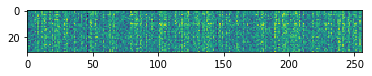

In [188]:
plt.imshow(model.get_weights(var))

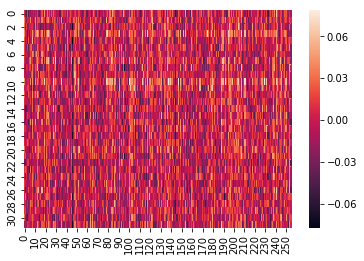

In [189]:
import seaborn as sns
sns.heatmap(model.get_weights(var))